In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import scipy.interpolate
import sys
import functools
from gfile_helpers import read_gfile, write_gfile, plot_gfile
import time as pytime
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
from backend import jnp, conditional_decorator, jit, use_jax, fori_loop, put, cross, dot, sign, pressfun, iotafun
from backend import get_needed_derivatives, unpack_x, rms, jacfwd, jacrev

from zernike import ZernikeTransform, get_zern_basis_idx_dense, get_double_four_basis_idx_dense, axis_posn, symmetric_x
from zernike import fringe_to_lm, lm_to_fringe, zern, zern_radial, fourzern
from init_guess import get_initial_guess_scale_bdry
from boundary_conditions import compute_bc_err_four, compute_bc_err_RZ, compute_lambda_err
from plotting import plot_IC, plot_fb_err, plot_coord_surfaces, plot_coeffs
from equilibrium_dynamics import compute_accel_error_spectral
from force_balance import compute_force_error_nodes, compute_coordinate_derivatives, compute_jacobian, compute_covariant_basis
from force_balance import compute_B_field, compute_J_field, compute_contravariant_basis
from nodes import get_nodes

Using JAX float64


/home/fouriest/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
# rcParams['axes.prop_cycle'] =  color_cycle
rcParams['axes.prop_cycle'] =  color_cycle + dash_cycle

labelsize=10
ticksize=8

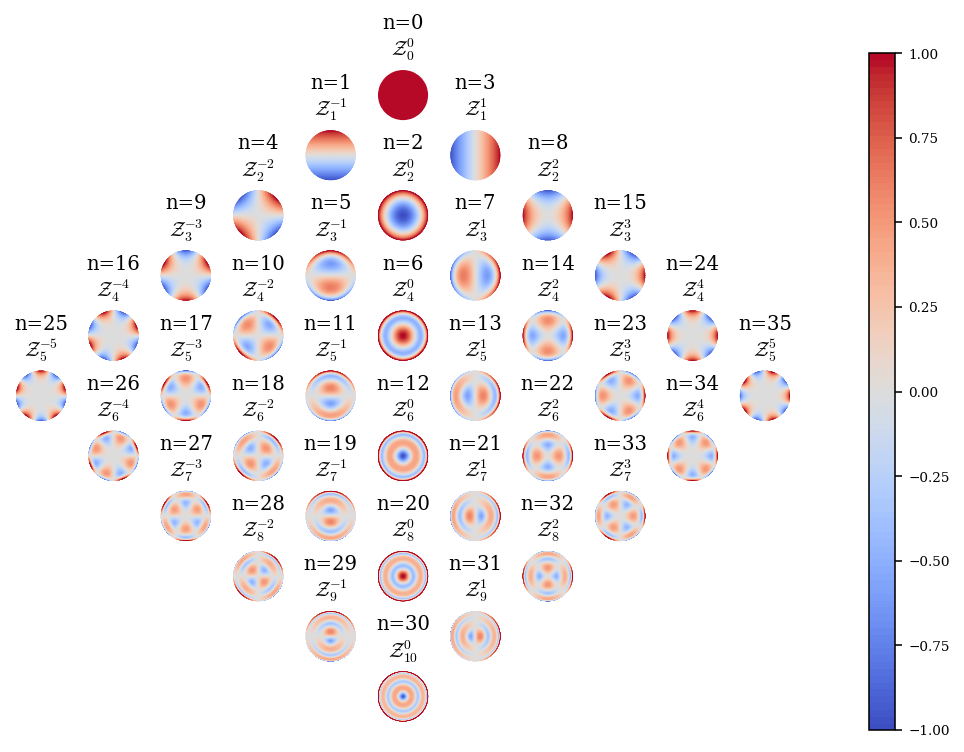

In [4]:
fig = plt.figure(figsize=(9,6))

mmax = 5
npts = 100
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
levels = np.linspace(-1,1,npts)
lmax = np.max(lm[:,0])
ax = {i:{} for i in range(lmax+1)}
gs = matplotlib.gridspec.GridSpec(lmax+1, 2*(mmax+1)) 
for l,m in lm:
    r = np.linspace(0,1,npts)
    v = np.linspace(0,2*jnp.pi,npts)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    Z = zern(rr.flatten(),vv.flatten(),l,m,0,0).reshape((npts,npts))
    
    ax[l][m] = plt.subplot(gs[l,m+mmax:m+mmax+2],projection='polar')
    ax[l][m].set_title('n=' + str(lm_to_fringe(l,m)) + '\n$\mathcal{Z}_{' + str(l) + '}^{' + str(m) + '}$')
    ax[l][m].axis('off')
    im = ax[l][m].contourf(v,r,Z,levels=levels,cmap='coolwarm')
#     ax[l][m].plot(v,jnp.ones_like(v),lw=2,c='k')

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.subplots_adjust(right=.8)
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_ticks(np.linspace(-1, 1, 9))

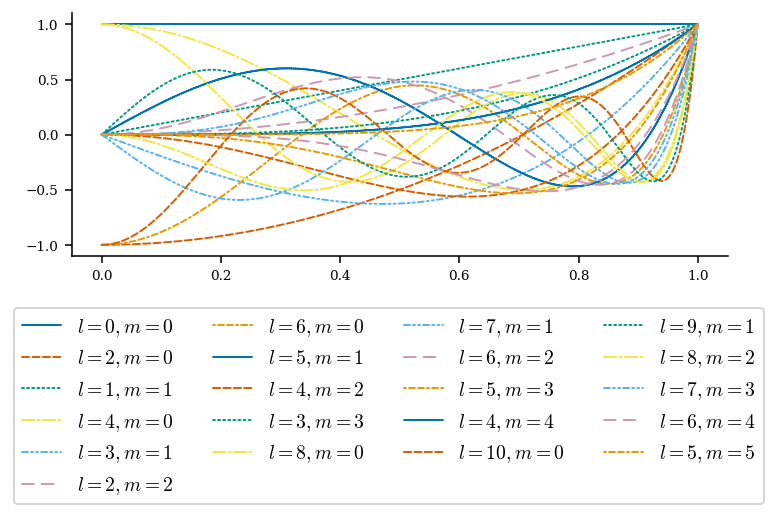

In [5]:
fig, ax = plt.subplots()

mmax = 5
npts = 1000
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
r = np.linspace(0,1,npts)

for l,m in lm:
    if (l-m)%2 == 0 and m>=0:
        ax.plot(r,zern_radial(r,l,m),lw=1,label='$l={},m={}$'.format(l,m))
plt.subplots_adjust(bottom=.45)
fig.legend(ncol=4, loc='lower center',)

In [52]:
cR = cR_init
cZ = cZ_init
cL = cL_init

N_nodes = nodes[0].size
r = nodes[0]
axn = jnp.where(r == 0)[0]
# value of r one step out from axis
r1 = np.min(r[r != 0])
r1idx = np.where(r == r1)[0]

pres = pressfun(r,0,pressfun_params)
presr = pressfun(r,1, pressfun_params)

# compute coordinates, fields etc.
coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
cov_basis = compute_covariant_basis(coord_der)
jacobian = compute_jacobian(coord_der,cov_basis)
B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
J_field = compute_J_field(B_field, jacobian, nodes, axn)
con_basis = compute_contravariant_basis(coord_der, cov_basis, jacobian, nodes, axn)

# helical basis vector
beta = B_field['B^zeta']*con_basis['e^theta'] - B_field['B^theta']*con_basis['e^zeta']

# force balance error in radial and helical direction
Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
Fbeta = J_field['J^rho']

radial  = jnp.sqrt(con_basis['g^rr']) * jnp.sign(dot(con_basis['e^rho'],cov_basis['e_rho'],0));
helical = jnp.sqrt(con_basis['g^vv']*B_field['B^zeta']**2 + con_basis['g^zz']*B_field['B^theta']**2 \
               - 2*con_basis['g^vz']*B_field['B^theta']*B_field['B^zeta']) * sign(
    dot(beta,cov_basis['e_theta'],0))*sign(dot(beta,cov_basis['e_zeta'],0));
put(helical,axn,jnp.sqrt(con_basis['g^vv'][axn]*B_field['B^zeta'][axn]**2) * sign(B_field['B^zeta'][axn]))

F_err = jnp.concatenate([Frho*radial,Fbeta*helical])


# force balance error in R,phi,Z
# F_err = Frho*con_basis['grad_rho'] + Fbeta*beta

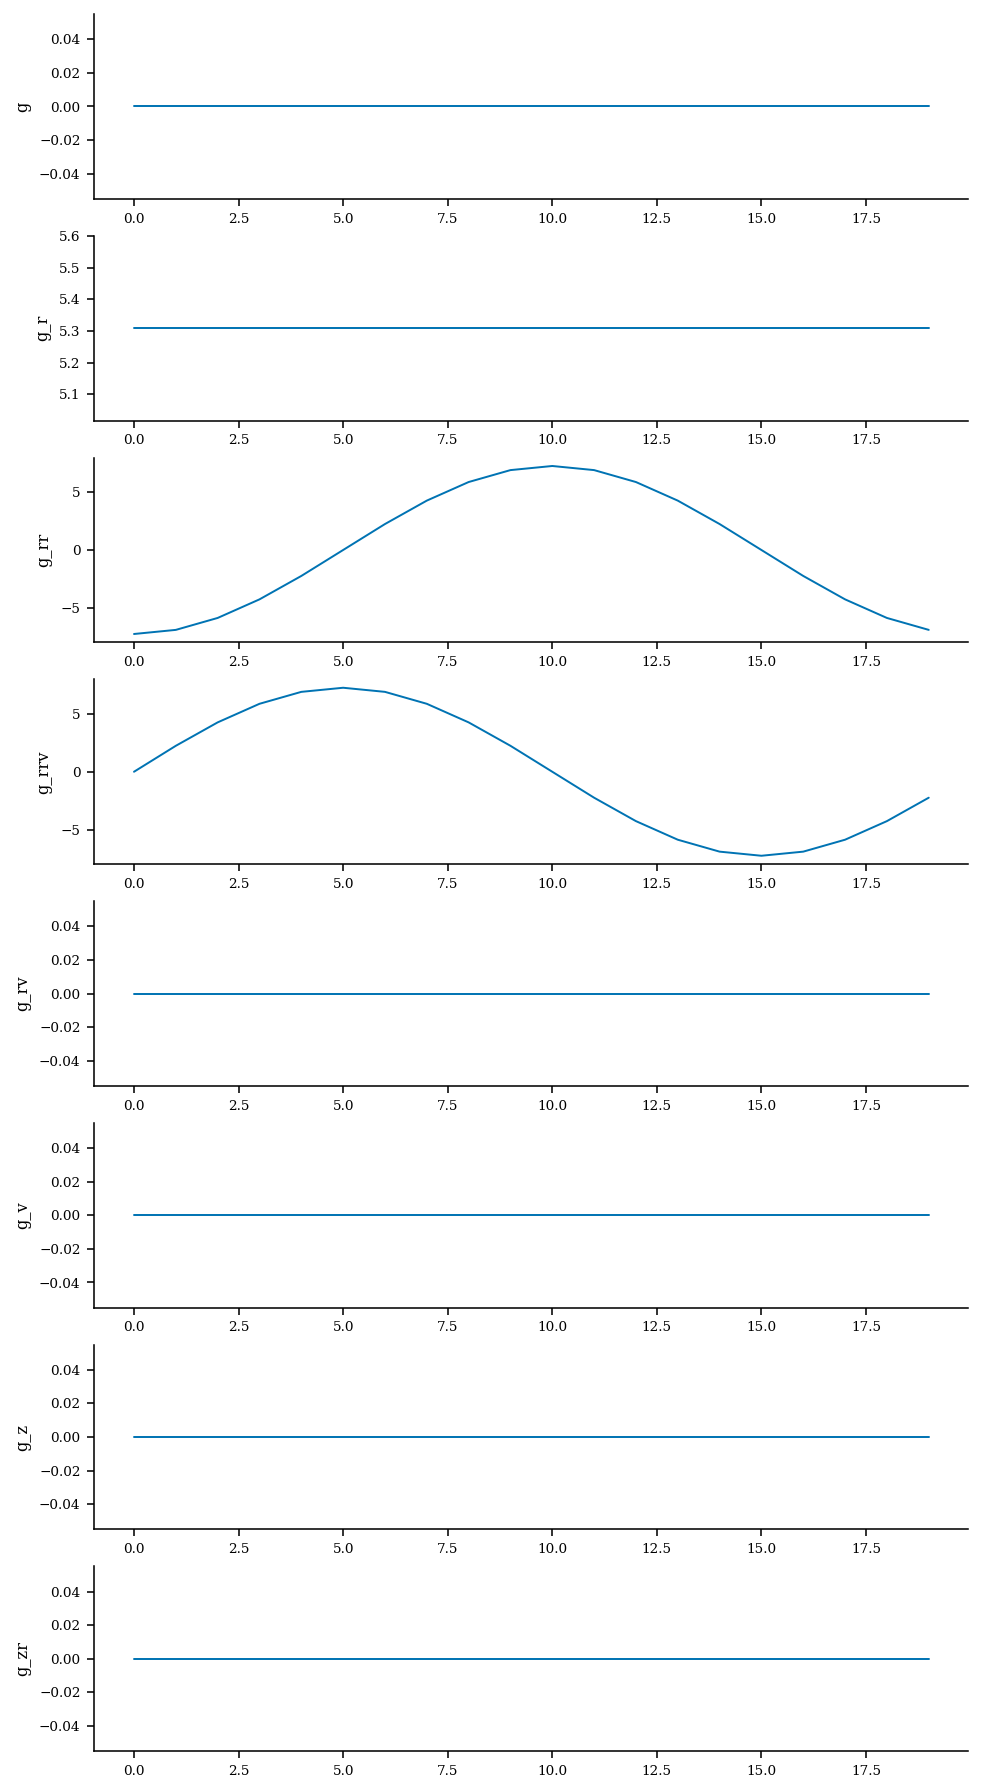

In [27]:
data = jacobian
fig, ax = plt.subplots(len(data),figsize=(8,16))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

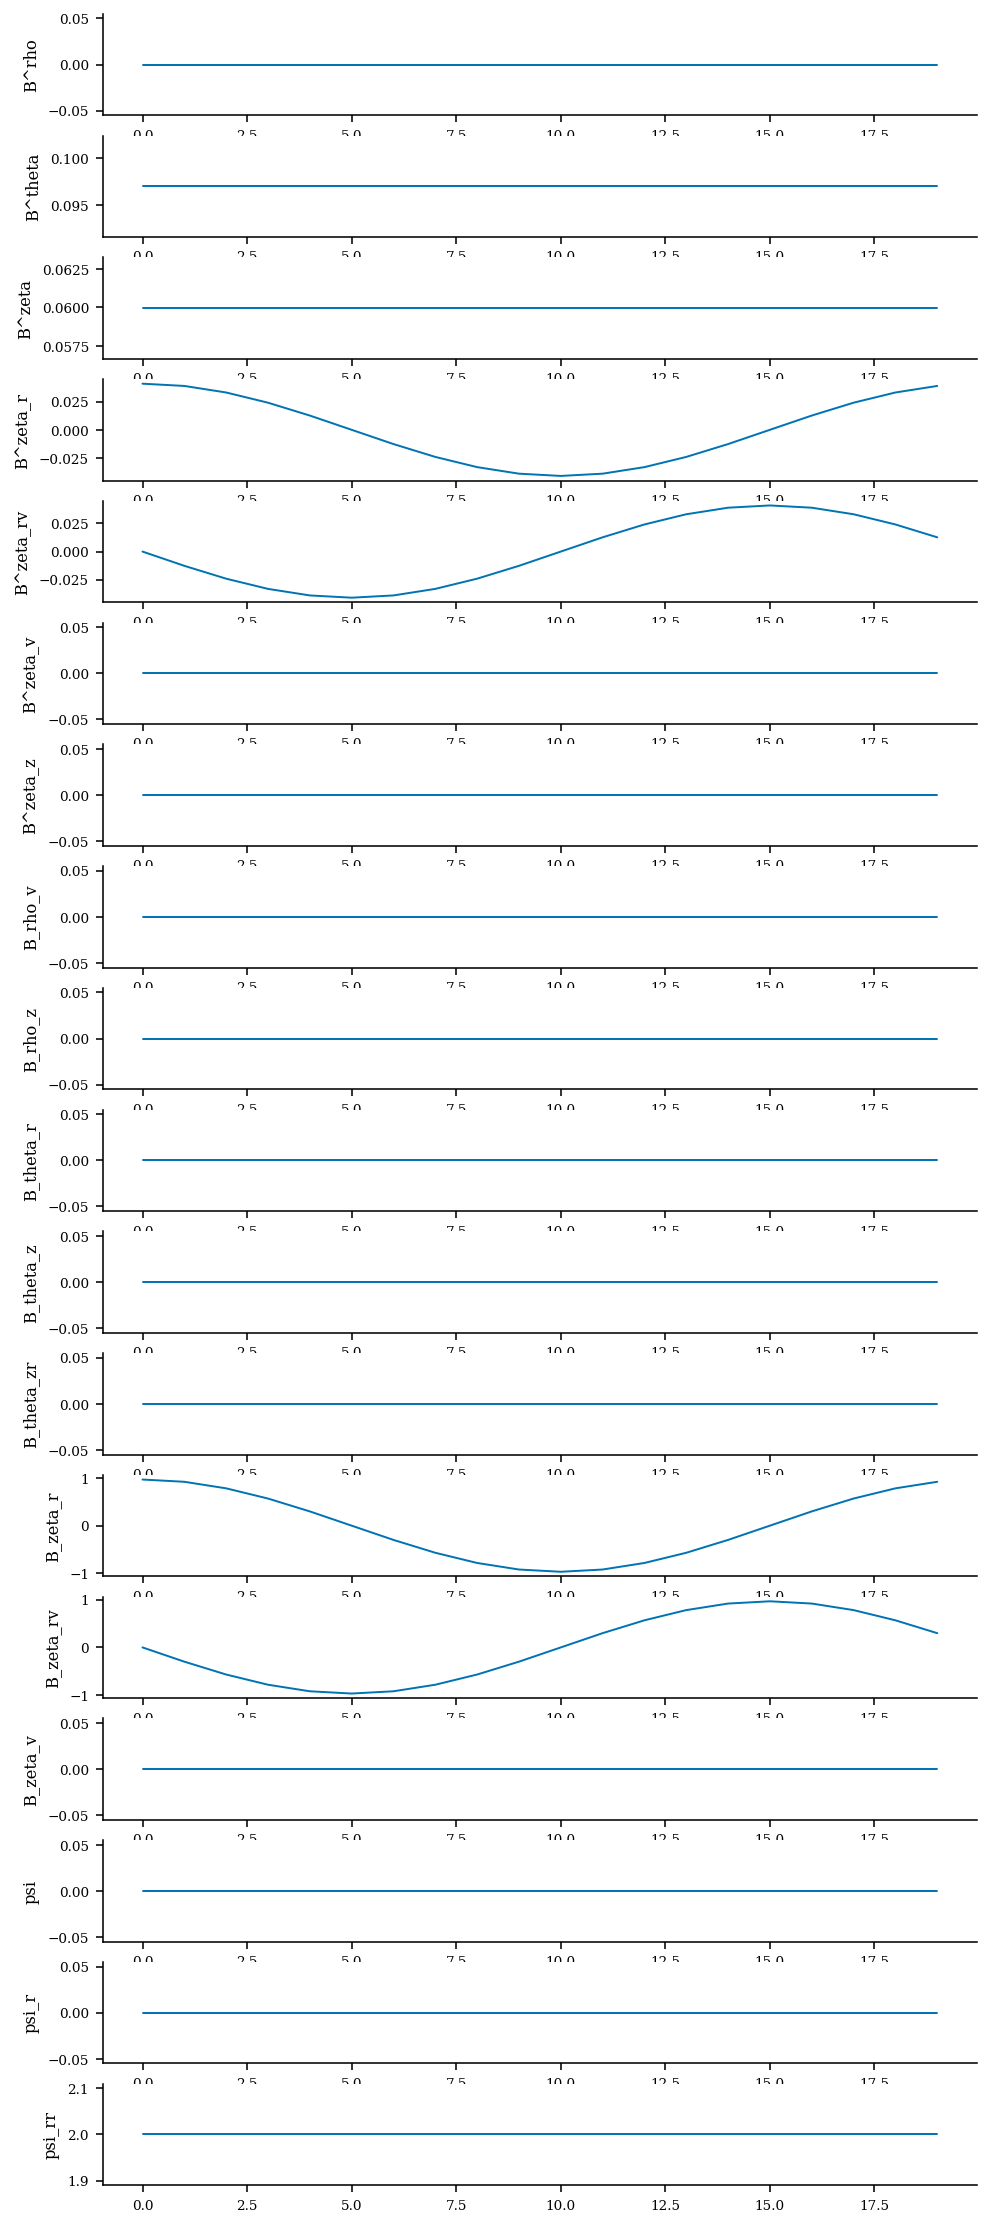

In [21]:
data = B_field
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

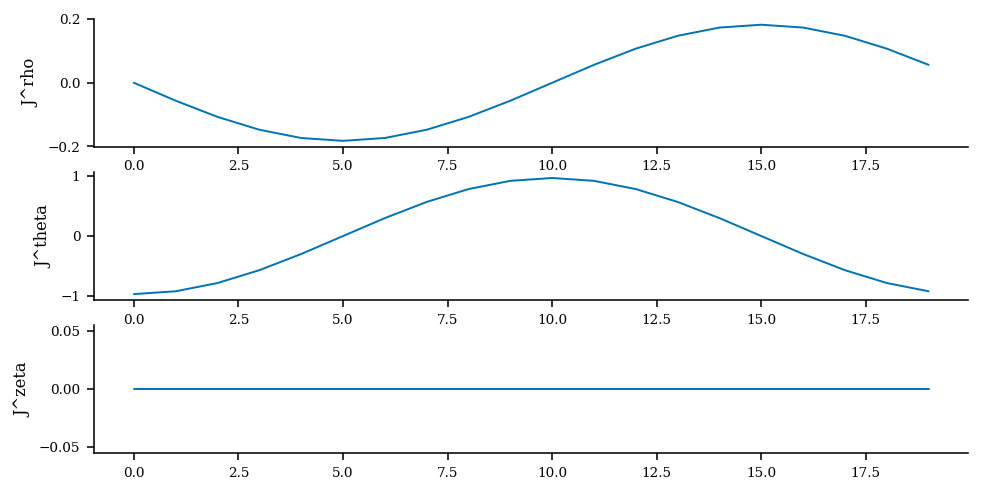

In [28]:
data = J_field
fig, ax = plt.subplots(len(data),figsize=(8,4))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

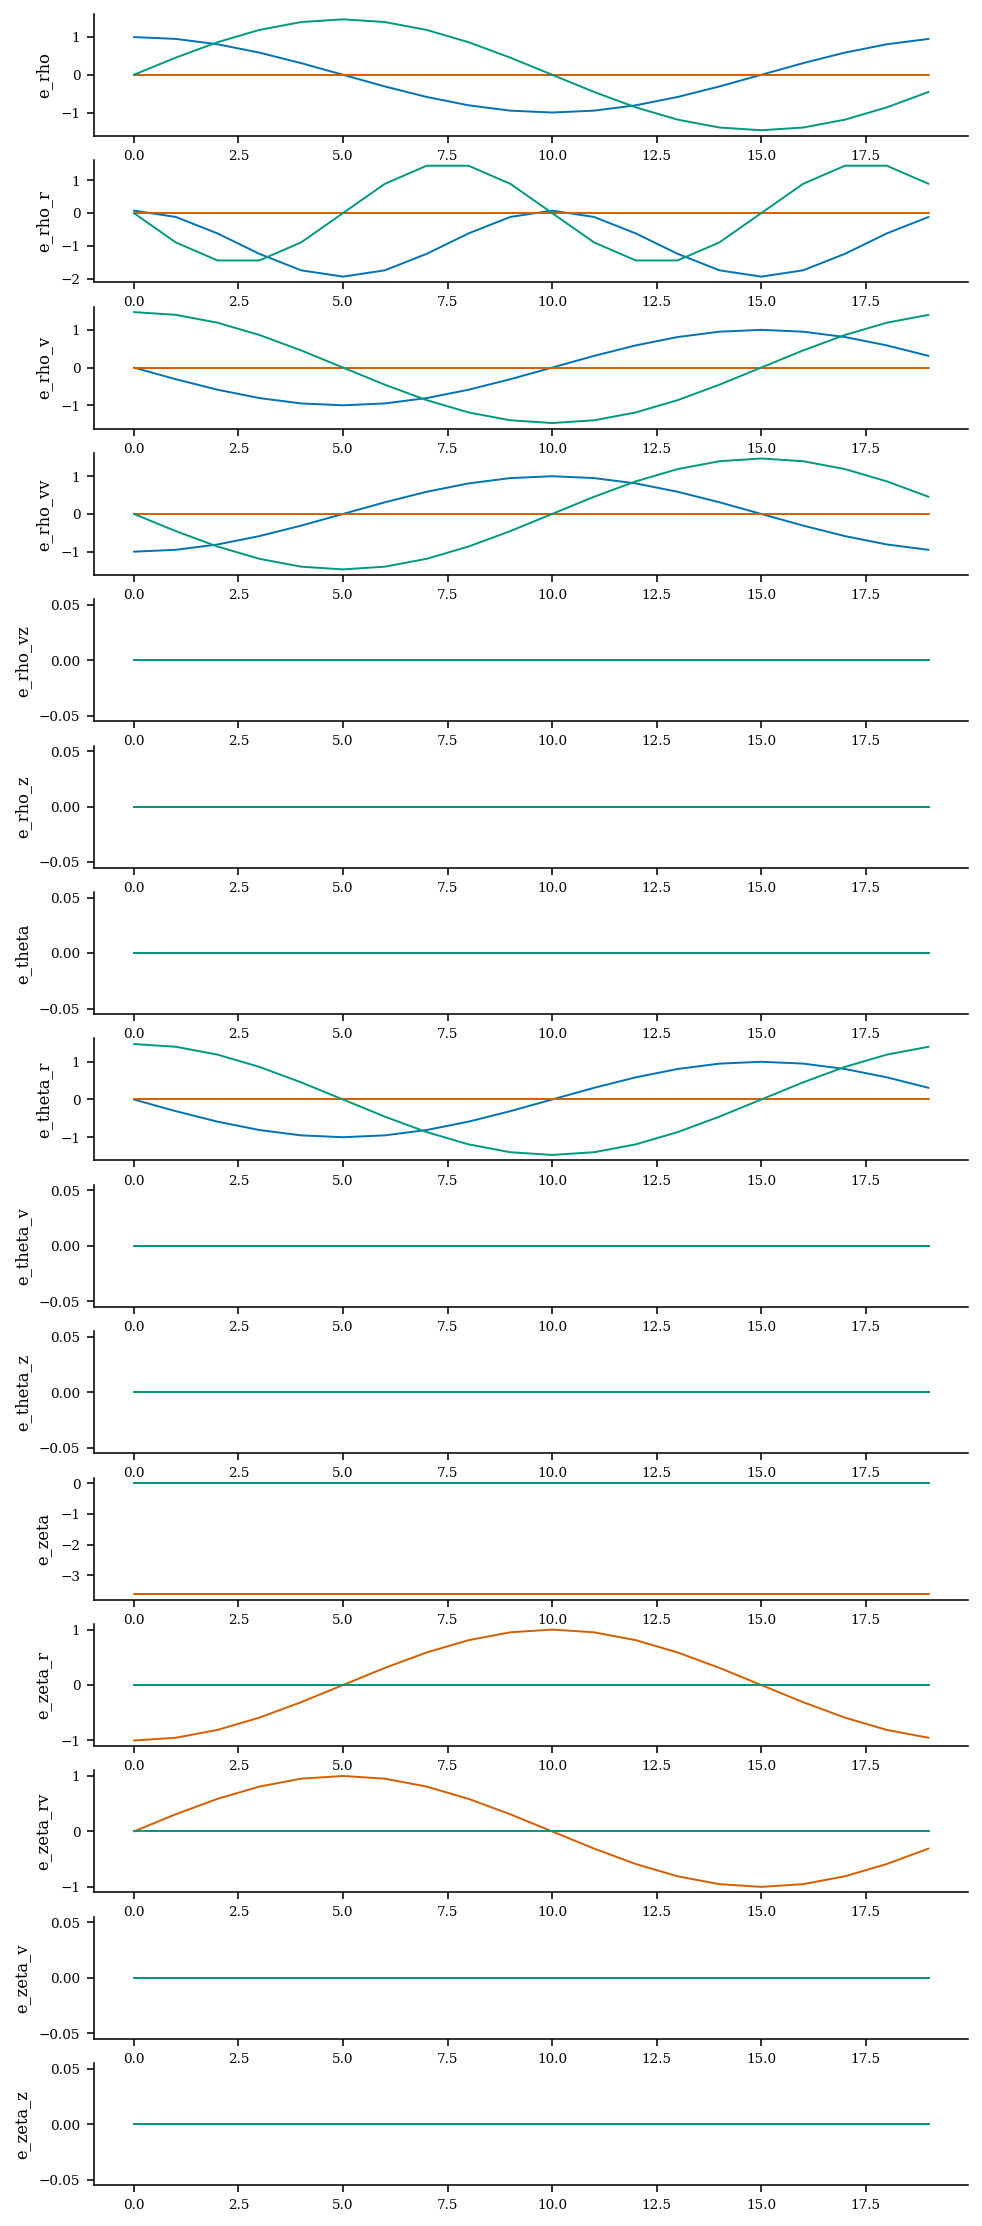

In [23]:
data = cov_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

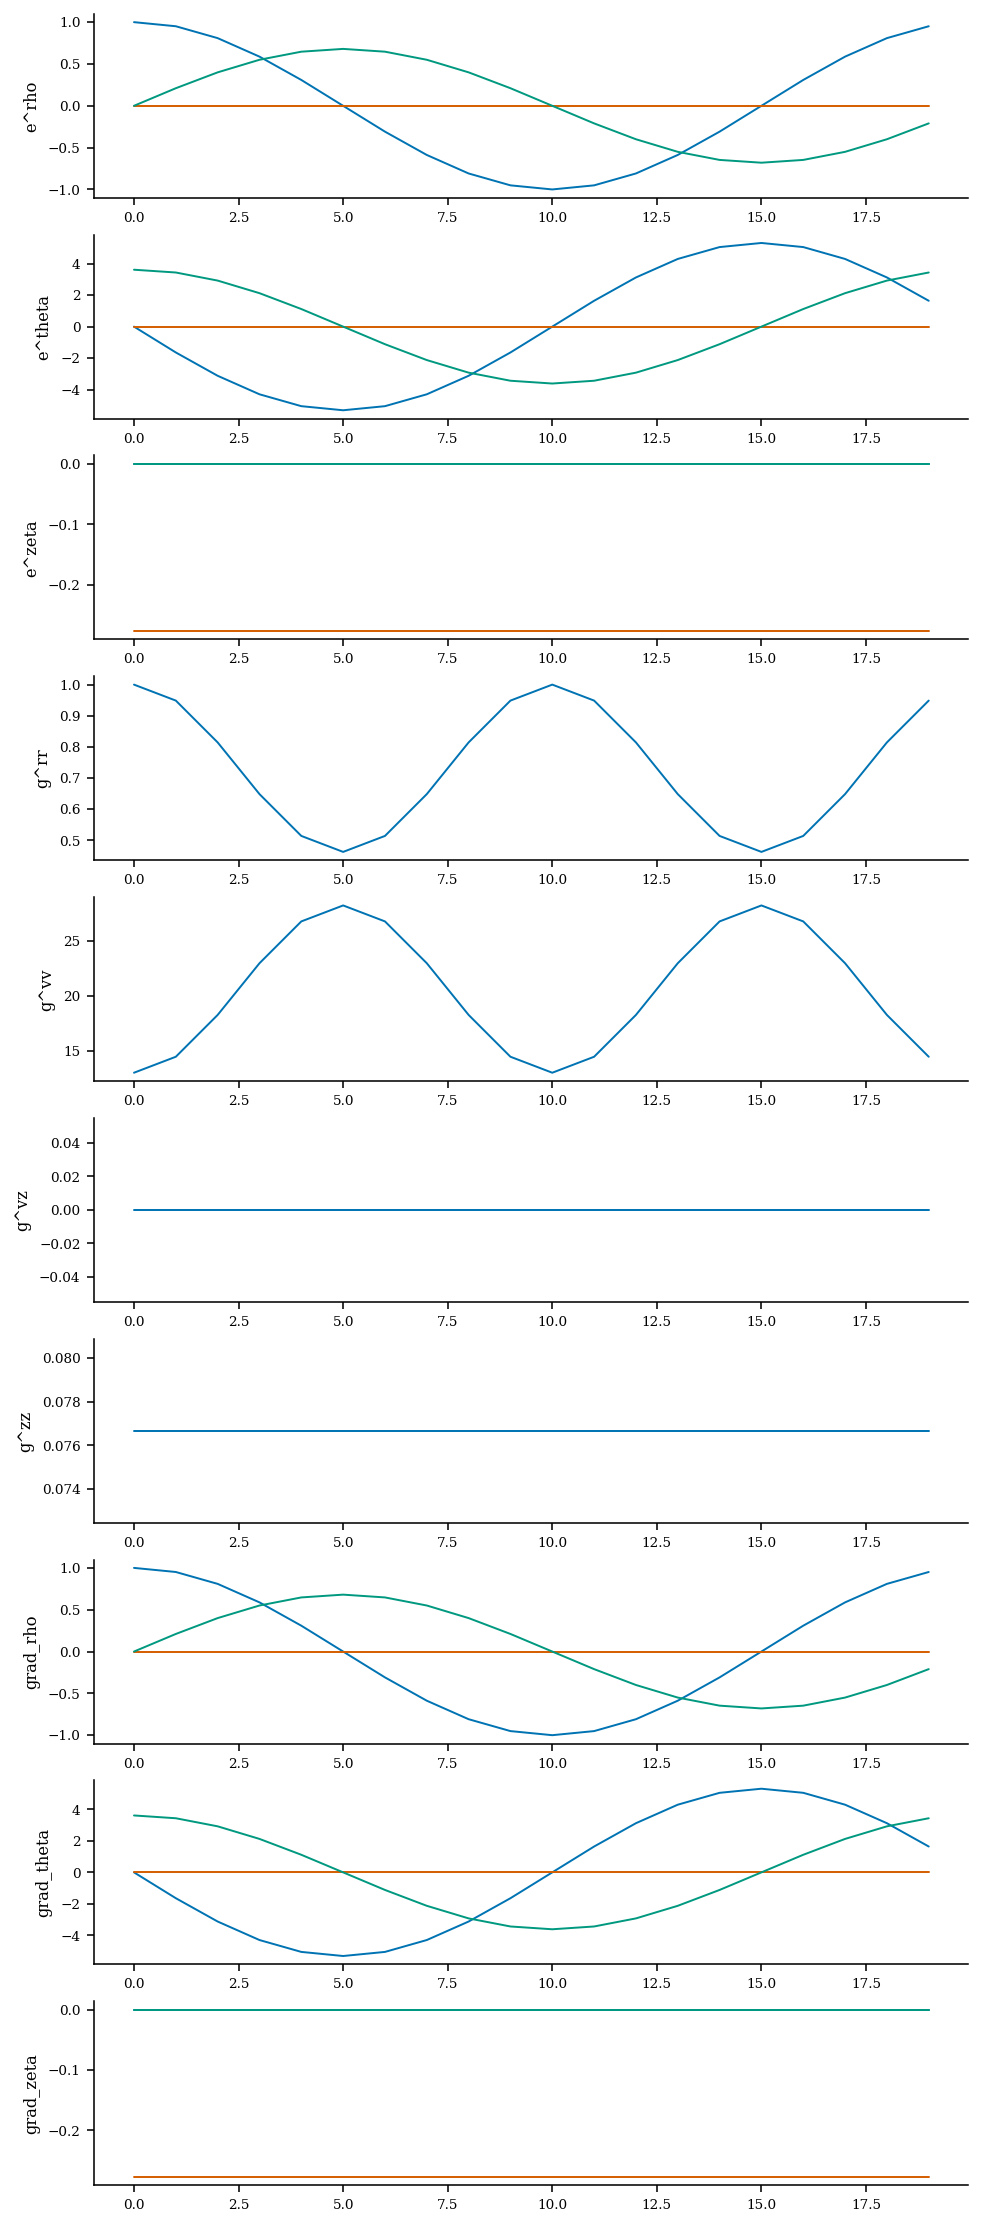

In [24]:
data = con_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val[axn],lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

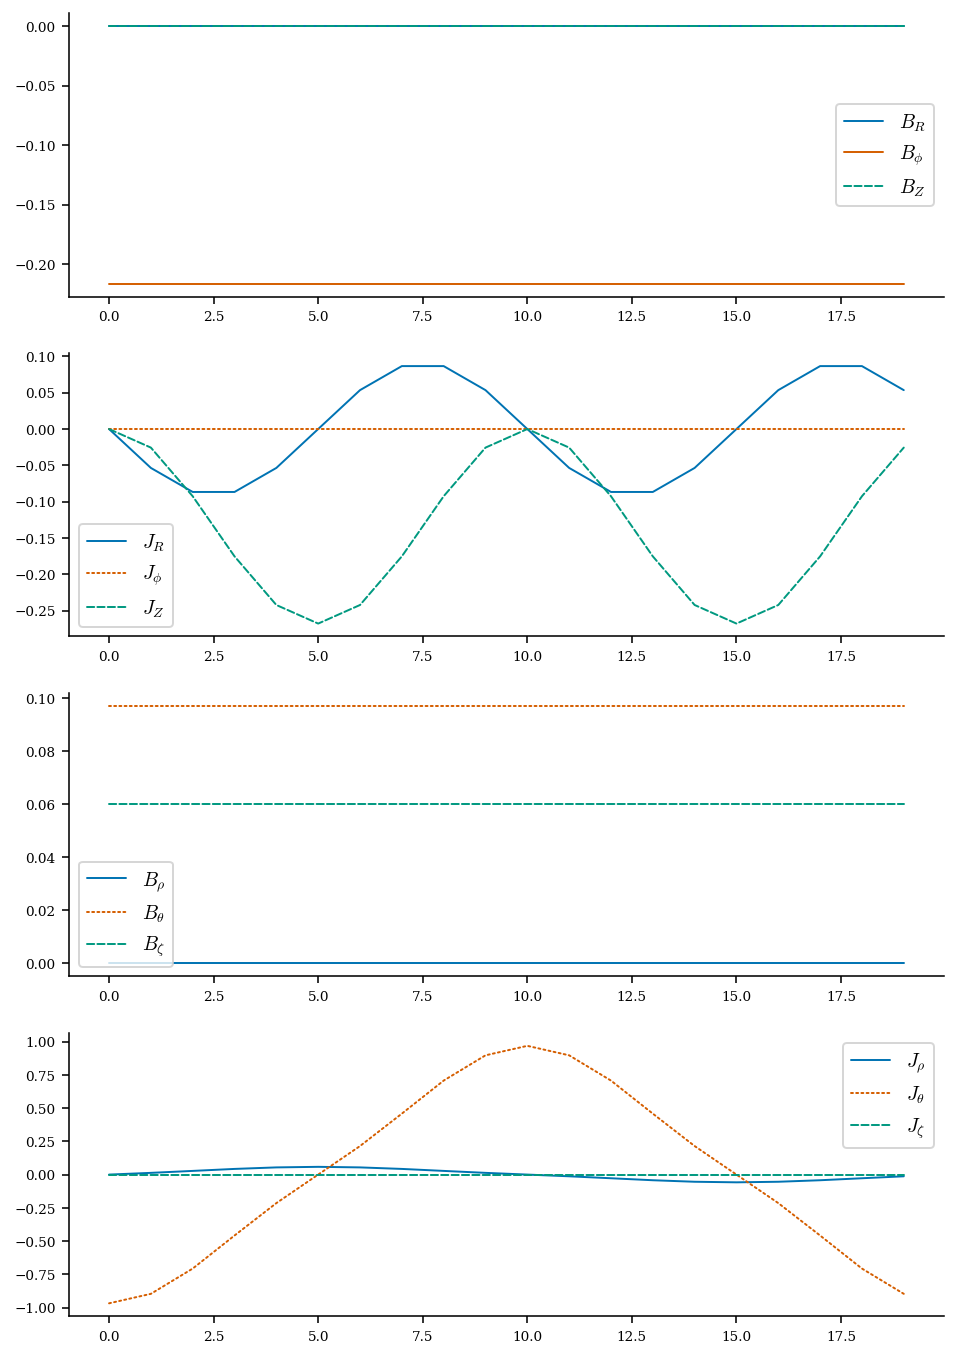

In [26]:
B = B_field['B^zeta']*cov_basis['e_zeta'] + B_field['B^theta']*cov_basis['e_theta'] \
    + B_field['B^rho']*cov_basis['e_rho']
# J = J_field['J^zeta']*cov_basis['e_zeta'] + J_field['J^theta']*cov_basis['e_theta'] \
#     + J_field['J^rho']*cov_basis['e_rho']
J = J_field['J^zeta']*cov_basis['e_zeta'] \
    + J_field['J^rho']*cov_basis['e_rho']

fig, ax = plt.subplots(4, figsize=(8,12))

ax[0].plot(B[0][axn],lw=1,label='$B_R$')
ax[0].plot(B[1][axn],lw=1,label='$B_\\phi$')
ax[0].plot(B[2][axn],lw=1,ls='--',label='$B_Z$')
ax[0].legend()
ax[1].plot(J[0][axn],lw=1,label='$J_R$')
ax[1].plot(J[1][axn],lw=1,ls=':',label='$J_\\phi$')
ax[1].plot(J[2][axn],lw=1,ls='--',label='$J_Z$')
ax[1].legend()
ax[2].plot(B_field['B^rho'][axn],lw=1,label='$B_\\rho$')
ax[2].plot(B_field['B^theta'][axn],lw=1,ls=':',label='$B_\\theta$')
ax[2].plot(B_field['B^zeta'][axn],lw=1,ls='--',label='$B_\zeta$')
ax[2].legend()
ax[3].plot(J_field['J^rho'][axn]*helical[axn],lw=1,label='$J_\\rho$')
ax[3].plot(J_field['J^theta'][axn]*radial[axn],lw=1,ls=':',label='$J_\\theta$')
ax[3].plot(J_field['J^zeta'][axn]*radial[axn],lw=1,ls='--',label='$J_\zeta$')
ax[3].legend()

In [5]:
%load_ext line_profiler
%lprun -f get_initial_guess_scale_bdry get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_poloidal,bdry_toroidal,zern_idx,NFP,mode=bdry_mode,nr=20,rcond=1e-6)


Timer unit: 1e-06 s

Total time: 27.8105 s
File: /home/fouriest/SCHOOL/Princeton/PPPL/DESC/init_guess.py
Function: get_initial_guess_scale_bdry at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def get_initial_guess_scale_bdry(bdryR,bdryZ,poloidal,toroidal,zern_idx,NFP,mode,nr=20,rcond=1e-6):
     5                                               """Generate initial guess by scaling boundary shape
     6                                               
     7                                               Args:
     8                                                   bdryR (ndarray, shape(N_bdry_vals,)): R coordinates of boundary, or spectral coefficients of boundary R shape
     9                                                   bdryZ (ndarray, shape(N_bdry_vals,)): Z coordinates of boundary, or spectral coefficients of boundary Z shape
    10                                                   poloidal (ndarray, shape

In [29]:
np.max(np.abs(bdryM))

10

precomputing Fourier-Zernike basis
computing initial guess


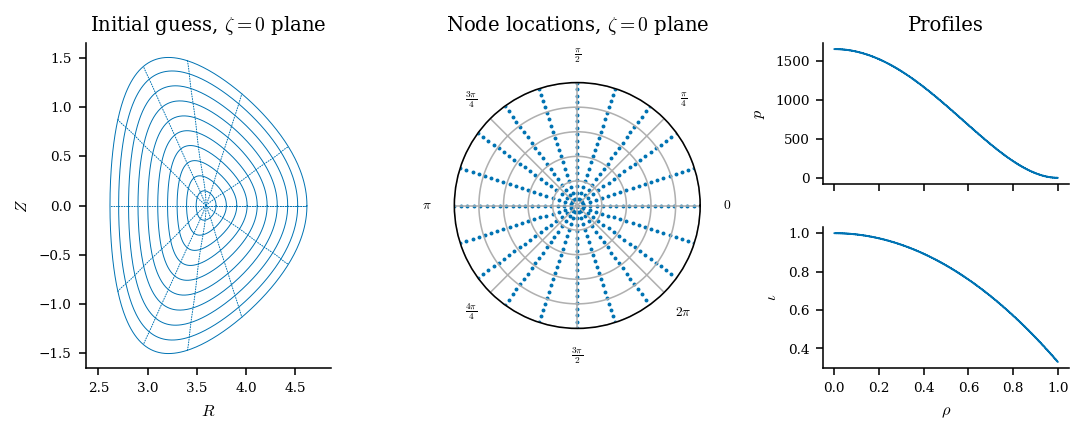

In [112]:
# Inputs
Psi_total = 1
M = 6
N = 0
NFP = 1
zern_idx = get_zern_basis_idx_dense(M,N)
lambda_idx = get_double_four_basis_idx_dense(M,N)

# profiles, polynomial basis
p0 = 1.65e3
pressfun_params = p0*np.array([1,0,-2,0,1])
iotafun_params = np.array([1,0,-.67])

# options
sym = True
error_mode = 'force'
bdry_mode = 'spectral'


# Node locations
r = np.linspace(0.,1,20)
dr = np.diff(r)[0]
v = np.linspace(0,2*jnp.pi,21)[:-1]
dv = np.diff(v)[0]
# z = np.linspace(0,2*np.pi/NFP,N*)
dz = 2*np.pi/NFP
rr,vv = np.meshgrid(r,v,indexing='ij')
rr = rr.flatten()
vv = vv.flatten()
zz = np.zeros_like(rr)
nodes = np.stack([rr,vv,zz])
dr = dr*np.ones_like(rr)
dv = dv*np.ones_like(vv)
dz = dz*np.ones_like(zz)
volumes = np.stack([dr,dv,dz])
axn = np.where(rr == 0)[0]

# interpolator
print('precomputing Fourier-Zernike basis')
derivatives = get_needed_derivatives('force')
zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)


# Boundary Shape as fourier series
bdryM = jnp.arange(-M,M+1)
bdryN = jnp.arange(-N,N+1)
bdryM, bdryN = jnp.meshgrid(bdryM, bdryN, indexing='ij')
bdryM = bdryM.flatten()
bdryN = bdryN.flatten()
bdryR = jnp.zeros(len(bdryM),dtype=jnp.float64)
bdryZ = jnp.zeros(len(bdryM),dtype=jnp.float64)

# bndryR = [0.000; 0.00; 3.51; -1.00; 0.106];
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 0, bdryN == 0))[0], 3.51)
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 1, bdryN == 0))[0], -1.0)
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 2, bdryN == 0))[0], 0.106)
#bndryZ = [0.160; 1.47; 0.00;  0.00; 0.000];
bdryZ = put(bdryZ, jnp.where(jnp.logical_and(bdryM == -1, bdryN == 0))[0], 1.47)
bdryZ = put(bdryZ, jnp.where(jnp.logical_and(bdryM == -2, bdryN == 0))[0], 0.160)

bdry_poloidal = bdryM
bdry_toroidal = bdryN

# # Boundary shape in real space
# bdry_mode = 'real'
# bdry_theta = np.linspace(0,2*np.pi,101)
# bdry_psi = np.zeros_like(bdry_theta)
# b = .75
# a = 2
# R0 = 2
# Z0 = 0
# bdryR = R0 + b*np.cos(bdry_theta)
# bdryZ = Z0 + a*np.sin(bdry_theta)
# bdry_poloidal = bdry_theta
# bdry_toroidal = bdry_psi



if sym:
    sym_mat = symmetric_x(M,N)
else:
    sym_mat = np.eye(2*len(zern_idx) + len(lambda_idx))

if error_mode == 'force':
    equil_fun = compute_force_error_nodes
elif error_mode == 'accel':
    equil_fun = compute_accel_error_spectral
if bdry_mode == 'real':
    bdry_fun = compute_bc_err_RZ
elif bdry_mode == 'spectral':
    bdry_fun = compute_bc_err_four


# initial guess
print('computing initial guess')
cR_init,cZ_init = get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_poloidal,bdry_toroidal,zern_idx,NFP,mode=bdry_mode,nr=20,rcond=1e-6)
cL_init = np.zeros(len(lambda_idx))
x_init = jnp.matmul(sym_mat.T,jnp.concatenate([cR_init,cZ_init,cL_init]))

# weights
weights = {'F':1e5,     # force balance error
           'B':1e4,     # error in bdry
           'L':1e4}     # error in sum lambda_mn


nodes = jnp.asarray(nodes)
volumes = jnp.asarray(volumes)

args = (zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,
        volumes,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,bdry_fun,weights,sym_mat)


fig, ax = plot_IC(cR_init, cZ_init, zern_idx, NFP, nodes, pressfun_params, iotafun_params)


In [113]:
@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,17)), use_jax)
def lstsq_obj(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
              Psi_total,volumes,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,bdry_fun,weights,sym_mat):
    
    cR,cZ,cL = unpack_x(jnp.matmul(sym_mat,x),len(zern_idx))
    errRf,errZf = equil_fun(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,volumes)
    errRb,errZb = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL0 = compute_lambda_err(cL,lambda_idx,NFP)
    # divide through by size of the array so weighting isn't thrown off by more points
    loss = jnp.concatenate([weights['F']*errRf.flatten()/errRf.size,   
                            weights['F']*errZf.flatten()/errZf.size,
                            weights['B']*errRb.flatten()/errRb.size,
                            weights['B']*errZb.flatten()/errZb.size,
                            weights['L']*errL0.flatten()/errL0.size])
    return loss

def callback(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
             Psi_total,volumes,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,bdry_fun,weights,sym_mat):
    
    cR,cZ,cL = unpack_x(jnp.matmul(sym_mat,x),len(zern_idx))
    errRf,errZf = equil_fun(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,volumes)
    errRb,errZb = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL0 = compute_lambda_err(cL,lambda_idx,NFP)
    
    errRf_rms = rms(errRf)
    errZf_rms = rms(errZf)
    errRb_rms = rms(errRb)
    errZb_rms = rms(errZb)
    errL0_rms = rms(errL0)
    
    loss = np.concatenate([weights['F']*errRf.flatten(),
                           weights['F']*errZf.flatten(),
                           weights['B']*errRb.flatten(),
                           weights['B']*errZb.flatten(),
                           weights['L']*errL0.flatten()])
    loss_rms = jnp.sum(loss**2)
    print('Weighted Loss: {:10.3e}  errRf: {:10.3e}  errZf: {:10.3e}  errRb: {:10.3e}  errZb: {:10.3e}  errL0: {:10.3e}'.format(
    loss_rms,errRf_rms,errZf_rms,errRb_rms,errZb_rms,errL0_rms))


if use_jax:
    lstsq_obj = jit(lstsq_obj, static_argnums=np.arange(len(args))+1)
    jac = jit(jacfwd(lstsq_obj),static_argnums=np.arange(len(args))+1)
    print('compiling')
    foo = lstsq_obj(x_init,*args).block_until_ready() 
    foo = jac(x_init,*args).block_until_ready() 
    print('done compilation')
else:
    jac = '2-point'

compiling
done compilation


In [54]:
callback(x_init,*args)

Weighted Loss:  1.617e+06  errRf:  4.826e-03  errZf:  4.140e-03  errRb:  1.017e-14  errZb:  1.556e-15  errL0:  0.000e+00


In [7]:
%%timeit
cost = lstsq_obj(x_init,*args).block_until_ready() 

1.13 ms ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%%timeit
foo = jac(x_init,*args).block_until_ready() 

46.4 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [114]:
x1 = x_init #+ .001*np.random.normal(size=x_init.size)
callback(x1,*args)
out = scipy.optimize.least_squares(lstsq_obj,
                                   x1,
                                   args=args,
                                   jac=jac if use_jax else None,
                                   x_scale='jac',
                                   ftol=1e-6, 
                                   xtol=1e-6, 
                                   gtol=1e-6, 
                                   max_nfev=1000, 
                                   verbose=1)
x = out['x']

Weighted Loss:  7.406e+09  errRf:  4.257e-02  errZf:  6.296e-03  errRb:  2.178e-04  errZb:  3.238e-04  errL0:  0.000e+00
`ftol` termination condition is satisfied.
Function evaluations 103, initial cost 2.3146e+04, final cost 1.3418e-01, first-order optimality 1.11e-01.


In [115]:
print('Initial')
callback(x_init, *args)
print('Final')
callback(x, *args)

Initial
Weighted Loss:  7.406e+09  errRf:  4.257e-02  errZf:  6.296e-03  errRb:  2.178e-04  errZb:  3.238e-04  errL0:  0.000e+00
Final
Weighted Loss:  4.294e+04  errRf:  6.067e-05  errZf:  8.398e-05  errRb:  1.014e-06  errZb:  8.808e-07  errL0:  0.000e+00


initial: R0 = 3.592, Z0 = -0.000
final:   R0 = 3.616, Z0 = 0.000


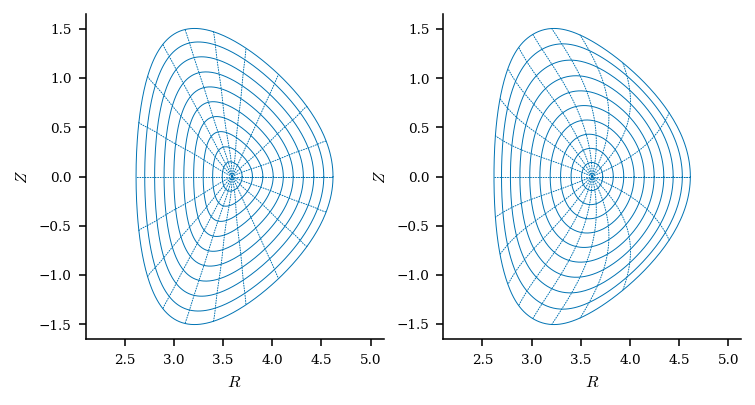

In [116]:
x = out['x']
cR,cZ,cL = unpack_x(jnp.matmul(sym_mat,x),len(zern_idx))
axis_init = axis_posn(cR_init,cZ_init,zern_idx,NFP)
axis_final = axis_posn(cR,cZ,zern_idx,NFP)
print('initial: R0 = {:.3f}, Z0 = {:.3f}'.format(axis_init[0],axis_init[1]))
print('final:   R0 = {:.3f}, Z0 = {:.3f}'.format(axis_final[0],axis_final[1]))

fig, ax = plt.subplots(1,2,figsize=(6,3))
plot_coord_surfaces(cR_init,cZ_init,zern_idx,NFP,nr=10,nt=20,ax=ax[0]);
plot_coord_surfaces(cR,cZ,zern_idx,NFP,nr=10,nt=20,ax=ax[1]);

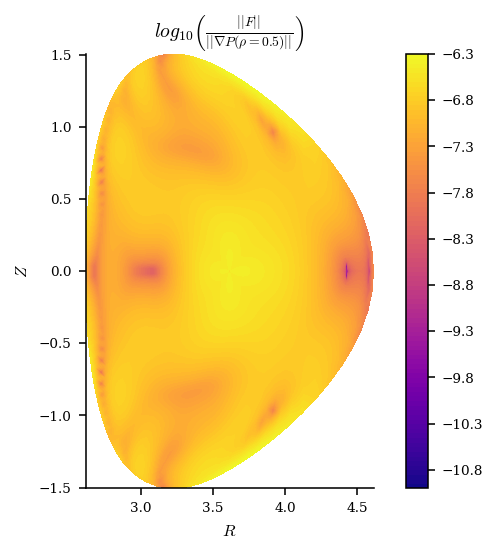

In [117]:
fig, ax = plt.subplots()
ax, im = plot_fb_err(cR,cZ,cL,zern_idx,lambda_idx,NFP,iotafun_params, pressfun_params, Psi_total,
                domain='real', normalize='global', ax=ax, log=True, cmap='plasma')
plt.colorbar(im)

In [111]:
from zernike import eval_double_fourier, double_fourier_basis

def compute_bc_err_four(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdryM,bdryN,NFP):
    """Compute boundary error in fourier coefficients
    
    Args:
        cR (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients of R
        cZ (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients of Z
        cL (ndarray, shape(2M+1)*(2N+1)): double Fourier coefficients of lambda
        zern_idx (ndarray, shape(Nc,3)): indices for R,Z spectral basis, ie an 
            array of [l,m,n] for each spectral coefficient
        lambda_idx (ndarray, shape(Nlambda,2)): indices for lambda spectral basis, 
            ie an array of [m,n] for each spectral coefficient
        bdryR (ndarray, shape(N_bdry_modes,)): R coefficients of boundary shape
        bdryZ (ndarray, shape(N_bdry_modes,)): Z coefficients of boundary shape
        bdryM (ndarray, shape(N_bdry_modes,)): poloidal mode numbers
        bdryN (ndarray, shape(N_bdry_modes,)): toroidal mode numbers
        NFP (int): number of field periods   
        
    Returns:
        errR ((ndarray, shape(N_bdry_pts,))): vector of R errors in boundary spectral coeffs
        errZ ((ndarray, shape(N_bdry_pts,))): vector of Z errors in boundary spectral coeffs
    """
    
    # get grid for bdry eval
    dimZernM = 2*np.max(np.abs(bdryM))+1
    dimFourN = 2*np.max(np.abs(bdryN))+1
    dv = 2*np.pi/(4*dimZernM)
    dz = 2*np.pi/(4*NFP*dimFourN)
    bdry_theta = jnp.arange(0,2*jnp.pi,dv)
    bdry_phi = jnp.arange(0,2*jnp.pi/NFP,dz)
    bdry_theta, bdry_phi = jnp.meshgrid(bdry_theta,bdry_phi,indexing='ij')
    bdry_theta = bdry_theta.flatten()
    bdry_phi = bdry_phi.flatten()

    L = eval_double_fourier(cL,lambda_idx,NFP,bdry_theta,bdry_phi)

    # find values of R,Z at pts specified
    rho = jnp.ones_like(bdry_theta)
    vartheta = jnp.pi - bdry_theta - L
    zeta = -bdry_phi
    zern_bdry_interp = jnp.stack([fourzern(rho,vartheta,zeta,lmn[0],lmn[1],lmn[2],NFP,0,0,0) for lmn in zern_idx]).T
    R = jnp.matmul(zern_bdry_interp,cR).flatten()
    Z = jnp.matmul(zern_bdry_interp,cZ).flatten()

    four_bdry_interp = jnp.stack([double_fourier_basis(bdry_theta,bdry_phi,m,n,NFP) for m, n in zip(bdryM,bdryN)]).T

    cRb, cZb = jnp.linalg.lstsq(four_bdry_interp,jnp.array([R,Z]).T,rcond=None)[0].T

    # compute errors
    errR = cRb - bdryR
    errZ = cZb - bdryZ
    return errR,errZ


In [35]:
errR,errZ = compute_bc_err_four(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdryM,bdryN,NFP)
print(max(abs(errR)))
print(max(abs(errZ)))

8.561768182580205e-05
7.472708821668929e-05


In [37]:
errR,errZ = compute_bc_err_four(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdryM,bdryN,NFP)
print(max(abs(errR)))
print(max(abs(errZ)))

8.561768164533357e-05
7.472708958394803e-05


In [39]:
errR,errZ = compute_bc_err_four(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdryM,bdryN,NFP)
print(max(abs(errR)))
print(max(abs(errZ)))

8.561768164619399e-05
7.472708958374506e-05


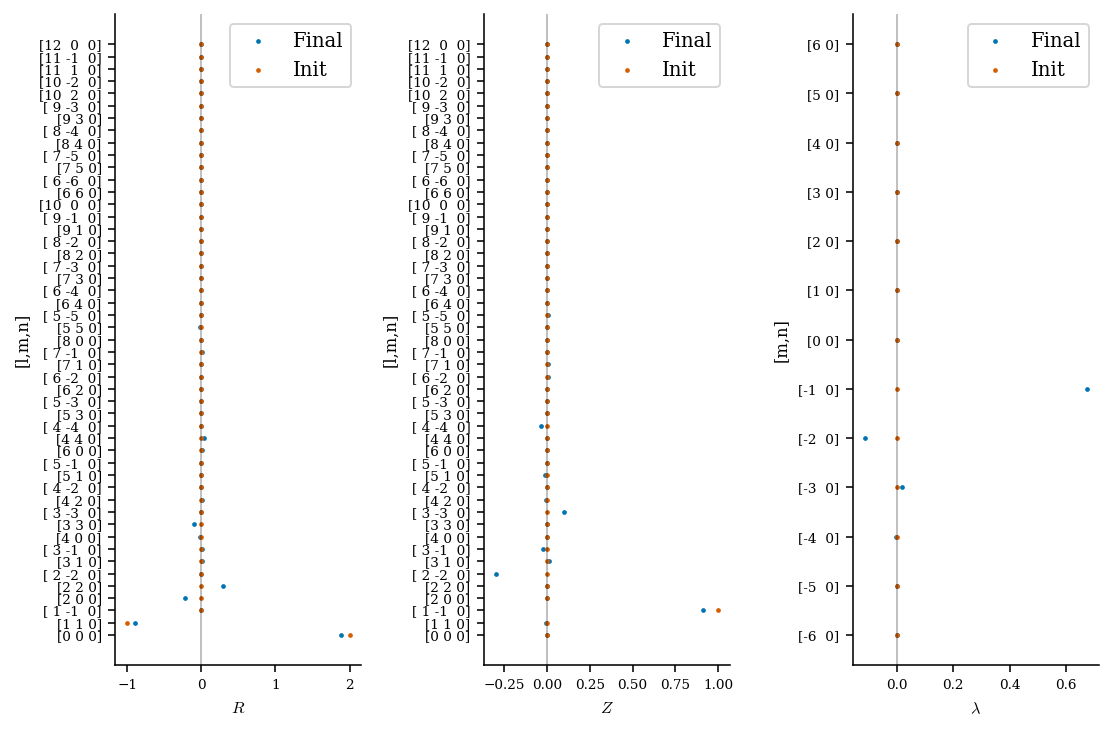

In [223]:
plot_coeffs(cR,cZ,cL,zern_idx,lambda_idx,cR_init,cZ_init,cL_init);

In [58]:
force_obj = jit(force_obj, static_argnums=np.arange(1,15))
force_jac = jit(jax.jacfwd(force_obj),static_argnums=np.arange(1,15))
bc_constraint_fun = jit(bc_constraint_fun, static_argnums=np.arange(1,15))
bc_jac = jit(jax.jacfwd(bc_constraint_fun),static_argnums=np.arange(1,15))

force_obj(x_init,*args).block_until_ready();
force_jac(x_init,*args).block_until_ready();
bc_constraint_fun(x_init,*args).block_until_ready();
bc_jac(x_init,*args).block_until_ready();

In [59]:
callback(x_init)

# slsqp_constraints=[{'type':'eq',
#                     'fun':lambda_constraint_fun,
#                     'jac':lambda_jac if use_jax else None,
#                     'args': args},
#                    {'type':'eq',
#                     'fun':bc_constraint_fun,
#                     'jac':bc_jac if use_jax else None,
#                     'args': args}]

trf_constraints = [scipy.optimize.NonlinearConstraint(lambda x: bc_constraint_fun(x,*args), 
                                                      -1e-3, 
                                                      1e-3, 
                                                      jac=lambda x: bc_jac(x,*args), 
                                                      keep_feasible=False, 
                                                      ),
                   scipy.optimize.LinearConstraint(get_lambda_constraint_matrix(M,N,NFP), 0, 0)
                  ]

# out = scipy.optimize.minimize(force_obj,
#                               x_init,
#                               args=args,
#                               method='SLSQP',
#                               jac=force_jac if use_jax else None,
#                               options={'disp':True,
#                                        'maxiter':500},
#                               constraints=slsqp_constraints,
#                               callback=callback
#                              )

out = scipy.optimize.minimize(force_obj,
                              x_init,
                              args=args,
                              method='trust-constr',
                              jac=force_jac if use_jax else None,
                              options={'disp':True,
                                       'maxiter':5000},
                              constraints=trf_constraints,
#                               callback=callback
                             )

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
The maximum number of function evaluations is exceeded.
Number of iterations: 5001, function evaluations: 5001, CG iterations: 5197, optimality: 2.50e-01, constraint violation: 1.05e-07, execution time: 7.9e+01 s.


In [60]:
callback(x_init)
callback(out['x'])

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
Loss:  1.259e+04  errF:  1.544e-02  errR:  2.934e-06  errZ:  2.339e-06  errL:  1.052e-07


In [90]:
def DESC_to_gfile(cR,cZ,iotafun_params,pressfun_params,Psi_total,M,N,NFP,nw=65,nh=65,nr=50,ntheta=50,npsi=1000, 
                  rdim=None,zdim=None,rleft=None,rcentr=None,zmid=None,axis_flux=0):

    g = {}
    g['date']=pytime.localtime()
    g['shot']=0
    g['time']=0
    g['efit']='DESC'
    g['nw']=nw
    g['nh']=nh


    # get poloidal flux (psi) as function of toroidal flux (rho)
    efitPsi = np.linspace(0,1,g['nw'])
    rho_n = np.linspace(1e-3,1,npsi)
    rho = 2*Psi_total*rho_n
    iota = iotafun(rho_n)
    psi = scipy.integrate.cumtrapz(rho*iota,rho_n,initial=axis_flux)
    psi_n = (psi - np.min(psi))/(np.max(psi)-np.min(psi))
    psi_n_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi_n)
    psi_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi)
    rho_n_of_psi_n = scipy.interpolate.CubicSpline(psi_n,rho_n)

    # get Bt
    vv = np.zeros_like(rho_n)
    zz = np.zeros_like(rho_n)
    nodes = np.stack([rho_n,vv,zz])
    axn = np.where(nodes[0]==0)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)
    coord_der = compute_coordinate_derivatives(cR,cZ,zernt)
    cov_basis = compute_covariant_basis(coord_der)
    jacobian = compute_jacobian(coord_der,cov_basis)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, cov_basis, iotafun_params)
    R = zernt.transform(cR,0,0,0).flatten()
    B = B_field['B^theta']*cov_basis['e_theta'] + B_field['B^zeta']*cov_basis['e_zeta']
    Bt = B[1]
    g['bcentr'] = np.linalg.norm(B[:,0])

    # compute profiles
    Fpol = scipy.interpolate.CubicSpline(rho_n,R*Bt)
    g['fpol'] = Fpol(rho_n_of_psi_n(efitPsi))
    g['ffprime'] = Fpol(rho_n_of_psi_n(efitPsi))*Fpol(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    g['pres'] = pressfun(rho_n_of_psi_n(efitPsi))
    g['pprime'] = pressfun(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    iotapsi = iotafun(rho_n_of_psi_n(efitPsi))
    qidx = np.where(iotapsi != 0)[0]
    g['qpsi'] = scipy.interpolate.CubicSpline(efitPsi[qidx],1/iotapsi[qidx])(efitPsi)


    # compute psi(R,Z)
    r = np.linspace(0,1,nr)
    v = np.linspace(0,2*np.pi,ntheta)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    rr = rr.flatten()
    vv = vv.flatten()
    zz = np.zeros_like(rr)
    nodes = np.stack([rr,vv,zz])
    axn = np.where(rr==0)[0]
    bdryn = np.where(rr==1)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)

    R = zernt.transform(cR,0,0,0).flatten()
    Z = zernt.transform(cZ,0,0,0).flatten()
    psiRZ = psi_of_rho_n(rr)

    g['rmaxis'] = np.mean(R[axn])
    g['zmaxis'] = np.mean(Z[axn])
    g['nbbbs'] = bdryn.size
    g['rbbbs'] = R[bdryn]
    g['zbbbs'] = Z[bdryn]
    g['axis_flux'] = np.mean(psiRZ[axn])
    g['boundary_flux'] = np.mean(psiRZ[bdryn])

    g['rdim'] = rdim if rdim else (np.max(R)-np.min(R))*1.5
    g['rcentr'] = rcentr if rcentr else (np.max(R)+np.min(R))/2
    g['zdim'] = zdim if zdim else (np.max(Z)-np.min(Z))*1.5
    g['zmid'] = zmid if zmid else (np.max(Z)+np.min(Z))/2
    g['rleft'] = rleft if rleft else g['rcentr'] - g['rdim']/2

    efitR = np.linspace(g['rleft'],g['rleft']+g['rdim'],g['nw'])
    efitZ = np.linspace(-g['zdim']/2,g['zdim']/2,g['nh'])
    efitRR,efitZZ = np.meshgrid(efitR,efitZ,indexing='ij')

    g['psirz'] = scipy.interpolate.griddata((R,Z),psiRZ,(efitRR,efitZZ),method='cubic').T
    g['psirz'][np.isnan(g['psirz'])] = g['boundary_flux']

    g['limitr'] = 0
    g['rlimitr'] = np.array([])
    g['zlimitr'] = np.array([])
    
    return g

In [91]:
plot_gfile(DESC_to_gfile(cR,cZ,iotafun,pressfun,Psi_total,M,N,NFP))

TypeError: iotafun() missing 2 required positional arguments: 'nu' and 'params'

In [61]:
import sympy
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt, fraction
from IPython.display import display, Math, Latex

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
BR = Function('B_\\rho', real=True)(rho,theta,zeta)
BT = Function('B_\\theta', real=True)(rho,theta,zeta)
BZ = Function('B_\\zeta', real=True)(rho,theta,zeta)



R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])

g = e_t.cross(e_z).dot(e_r)

JR = (BZ.diff(theta) - BT.diff(zeta))/g
JT = (BR.diff(zeta) - BZ.diff(rho))/g
JZ = (BT.diff(rho) - BR.diff(theta))/g

J = JR*e_r + JT*e_t + JZ*e_z
# J = simplify(J)


In [65]:
print('J_R num')
display(fraction(simplify(J)[0])[0].diff(rho))
print('J_R den')
display(fraction(simplify(J)[0])[1].diff(rho))

print('J_phi num')
display(fraction(simplify(J)[1])[0].diff(rho))
print('J_phi den')
display(fraction(simplify(J)[1])[1].diff(rho))

print('J_Z num')
display(fraction(simplify(J)[2])[0].diff(rho))
print('J_Z den')
display(fraction(simplify(J)[2])[1].diff(rho))

J_R num


(-Derivative(B_\rho(\rho, \theta, \zeta), \theta) + Derivative(B_\theta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho, \zeta) + (Derivative(B_\rho(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho, \theta) + (Derivative(B_\theta(\rho, \theta, \zeta), (\rho, 2)) - Derivative(B_\rho(\rho, \theta, \zeta), \rho, \theta))*Derivative(R(\rho, \theta, \zeta), \zeta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \theta))*Derivative(R(\rho, \theta, \zeta), (\rho, 2)) + (-Derivative(B_\zeta(\rho, \theta, \zeta), (\rho, 2)) + Derivative(B_\rho(\rho, \theta, \zeta), \rho, \zeta))*Derivative(R(\rho, \theta, \zeta), \theta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \rho, \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \rho, \theta))*Derivative(R(\rho, \theta, \zeta), \rho)

J_R den


(Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho) + (Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) - Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), \rho, \theta))*R(\rho, \theta, \zeta)

J_phi num


-Derivative(B_\theta(\rho, \theta, \zeta), (\rho, 2)) + Derivative(B_\rho(\rho, \theta, \zeta), \rho, \theta)

J_phi den


Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) - Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), \rho, \theta)

J_Z num


(-Derivative(B_\rho(\rho, \theta, \zeta), \theta) + Derivative(B_\theta(\rho, \theta, \zeta), \rho))*Derivative(Z(\rho, \theta, \zeta), \rho, \zeta) + (Derivative(B_\rho(\rho, \theta, \zeta), \zeta) - Derivative(B_\zeta(\rho, \theta, \zeta), \rho))*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + (Derivative(B_\theta(\rho, \theta, \zeta), (\rho, 2)) - Derivative(B_\rho(\rho, \theta, \zeta), \rho, \theta))*Derivative(Z(\rho, \theta, \zeta), \zeta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \theta))*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) + (-Derivative(B_\zeta(\rho, \theta, \zeta), (\rho, 2)) + Derivative(B_\rho(\rho, \theta, \zeta), \rho, \zeta))*Derivative(Z(\rho, \theta, \zeta), \theta) + (-Derivative(B_\theta(\rho, \theta, \zeta), \rho, \zeta) + Derivative(B_\zeta(\rho, \theta, \zeta), \rho, \theta))*Derivative(Z(\rho, \theta, \zeta), \rho)

J_Z den


(Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), \rho))*Derivative(R(\rho, \theta, \zeta), \rho) + (Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2)) - Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), \rho, \theta))*R(\rho, \theta, \zeta)

In [33]:
B_field.keys()

dict_keys(['B^rho', 'B^theta', 'B^zeta', 'B^zeta_r', 'B^zeta_rv', 'B^zeta_v', 'B^zeta_z', 'B_rho_v', 'B_rho_z', 'B_theta_r', 'B_theta_z', 'B_theta_zr', 'B_zeta_r', 'B_zeta_rv', 'B_zeta_v', 'psi', 'psi_r', 'psi_rr'])

In [34]:
coord_der.keys()

dict_keys(['0', 'R', 'R_r', 'R_rr', 'R_rrv', 'R_rrvv', 'R_rv', 'R_rvv', 'R_rz', 'R_v', 'R_vr', 'R_vv', 'R_vz', 'R_z', 'R_zr', 'R_zrv', 'R_zv', 'R_zz', 'Z', 'Z_r', 'Z_rr', 'Z_rrv', 'Z_rrvv', 'Z_rv', 'Z_rvv', 'Z_rz', 'Z_v', 'Z_vr', 'Z_vv', 'Z_vz', 'Z_z', 'Z_zr', 'Z_zrv', 'Z_zv', 'Z_zz'])

In [53]:
num = (-B_field['B_rho_v'] + B_field['B_theta_r'])*coord_der['R_z'] + (B_field['B_rho_z'] - B_field['B_zeta_r'])*coord_der['R_v'] \
    - (B_field['B_theta_z'] - B_field['B_zeta_v'])*coord_der['R_r']

dnum = (-B_field['B_rho_v'] + B_field['B_theta_r'])*coord_der['R_rz'] + (B_field['B_rho_z'] - B_field['B_zeta_r'])*coord_der['R_rv'] \
    - (B_field['B_theta_z'] - B_field['B_zeta_v'])*coord_der['R_rr'] + (-B_field['B_rho_rv'] + B_field['B_theta_rr'])*coord_der['R_z'] \
    + (B_field['B_rho_rz'] - B_field['B_zeta_rr'])*coord_der['R_v'] - (B_field['B_theta_rz'] - B_field['B_zeta_rv'])*coord_der['R_r']

den = (coord_der['R_r']*coord_der['Z_v'] - coord_der['R_v']*coord_der['Z_r'])*coord_der['R']

dden = (coord_der['R_rr']*coord_der['Z_v'] + coord_der['R_r']*coord_der['Z_rv']
        - coord_der['R_rv']*coord_der['Z_r'] - coord_der['R_v']*coord_der['Z_rr'])*coord_der['R'] + (coord_der['R_r']*coord_der['Z_v'] - coord_der['R_v']*coord_der['Z_r'])*coord_der['R_r']

KeyError: 'B_rho_rv'

In [66]:
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
X = Matrix([rho,theta,zeta])
R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])
psi = Function('\\Psi')(rho)
iota = Function('\iota')(rho)
covG = eye(3)
conG = eye(3)
covE = Matrix([e_r.T,e_t.T,e_z.T]).T
covE = simplify(covE)

g = e_t.cross(e_z).dot(e_r)
eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

conE = Matrix([eR.T,eT.T,eZ.T]).T
conE = simplify(conE)

for i in range(3):
    for j in range(3):
        covG[i,j] = covE[:,i].dot(covE[:,j])
        conG[i,j] = conE[:,i].dot(conE[:,j])

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ

conB = Matrix([0,BT,BZ])
conB = simplify(conB)

covB = covG*conB
covB = simplify(covB)

conJ = zeros(3,1)

for i in range(3):
    for j in range(3):
        conJ += covB[j].diff(X[i])*conE[:,i].cross(conE[:,j])

# conJ = simplify(conJ)

B = BZ*e_z + BT*e_t
J = covE*conJ

JxB = J.cross(B)


In [70]:
simplify(covB[0].diff(rho,rho))

(((Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), \rho))*(-Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), (\rho, 2), \theta) - 2*Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) - Derivative(R(\rho, \theta, \zeta), (\rho, 3))*Derivative(Z(\rho, \theta, \zeta), \theta) + Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \theta, \zeta), (\rho, 3)) + Derivative(Z(\rho, \theta, \zeta), \rho)*Derivative(R(\rho, \theta, \zeta), (\rho, 2), \theta) + 2*Derivative(Z(\rho, \theta, \zeta), (\rho, 2))*Derivative(R(\rho, \theta, \zeta), \rho, \theta)) + 2*(Derivative(R(\rho, \theta, \zeta), \rho)*Derivative(Z(\rho, \theta, \zeta), \rho, \theta) + Derivative(R(\rho, \theta, \zeta), (\rho, 2))*Derivative(Z(\rho, \theta, \zeta), \theta) - Derivative(R(\rho, \theta, \zeta), \theta)*Derivative(Z(\rho, \

In [103]:
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt
from sympy.vector import CoordSys3D, curl, gradient, divergence

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
X = Matrix([rho,theta,zeta])
R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)
dR = Function('{\delta}R')(rho,theta,zeta)
dZ = Function('{\delta}Z')(rho,theta,zeta)
xi_R = Function('\\xi_R')(rho,theta,zeta)
xi_P = Function('\\xi_\\phi')(rho,theta,zeta)
xi_Z = Function('\\xi_Z')(rho,theta,zeta)


xi = Matrix([xi_R,xi_P,xi_Z])

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])

de_r = Matrix([dR.diff(rho),   0,  dZ.diff(rho)])
de_t = Matrix([dR.diff(theta), 0,  dZ.diff(theta)])
de_z = Matrix([dR.diff(zeta),  dR, dZ.diff(zeta)])

psi_a = symbols("psi_a")
iota = Function('\iota')(rho)
pres = Function('p')(rho)
psi = psi_a*rho**2
psi = Function('\\Psi')(rho)
covG = eye(3)
conG = eye(3)
covE = Matrix([e_r.T,e_t.T,e_z.T]).T
covE = simplify(covE)

g = e_t.cross(e_z).dot(e_r)
eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

conE = Matrix([eR.T,eT.T,eZ.T]).T
conE = simplify(conE)

for i in range(3):
    for j in range(3):
        covG[i,j] = covE[:,i].dot(covE[:,j])
        conG[i,j] = conE[:,i].dot(conE[:,j])

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ





# conB = Matrix([0,BT,BZ])
# conB = simplify(conB)

# covB = covG*conB
# covB = simplify(covB)

# conJ = zeros(3,1)

# for i in range(3):
#     for j in range(3):
#         conJ += covB[j].diff(X[i])*conE[:,i].cross(conE[:,j])

# # conJ = simplify(conJ)

# B = BZ*e_z + BT*e_t
# J = covE*conJ

# JxB = J.cross(B)

In [76]:
g = Function('g')(rho,theta,zeta)
g = sqrt(g)
b_r = Function('b_\\rho')(rho,theta,zeta)
b_t = Function('b_\\theta')(rho,theta,zeta)
b_z = Function('b_\\zeta')(rho,theta,zeta)
b = Matrix([b_r,b_t,b_z])
mu0 = symbols('\mu_0')
coords = Matrix([rho,theta,zeta])
covB = 1/(2*pi*g)*b

JR = 1/(mu0*g)*(covB[2].diff(coords[1]) - covB[1].diff(coords[2]))
JT = 1/(mu0*g)*(covB[0].diff(coords[2]) - covB[2].diff(coords[0]))
JZ = 1/(mu0*g)*(covB[1].diff(coords[0]) - covB[0].diff(coords[1]))
conJ = Matrix([JR,JT,JZ])

eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ

conB = Matrix([0,BT,BZ])

F = g*((JT*BZ - JZ*BT)*eR - JR*BZ*eT + JR*BT*eZ)

In [78]:
simplify(F)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             (-(2*(-Derivative(b_\theta(\rho, \theta, \zeta), \zeta) + Derivative(b_\zeta(\rho, \theta, \zeta), \theta))*g(\rho, \theta, \zeta) + b_\theta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \zeta) - b_\zeta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \theta))*Derivativ

In [104]:
simplify(eZ)

Matrix([
[                        0],
[-1/R(\rho, \theta, \zeta)],
[                        0]])

In [36]:
print(latex(simplify(conG*g**2)))

\left[\begin{matrix}\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)} - \frac{\partial}{\partial \zeta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2}\right) R^{2}{\left(\rho,\theta,\zeta \right)} & - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} + \frac{\partial}{\partial \rho} Z{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right) R^{2}{\left(\rho,\theta,\zeta \right)} - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)

In [74]:
from sympy import symbols, Matrix, diff, pi

er_R, er_P, er_Z = symbols("R_rho phi_rho Z_rho")
ev_R, ev_P, ev_Z = symbols("R_theta phi_theta Z_theta")
ez_R, ez_P, ez_Z = symbols("R_\zeta R Z_\zeta")
psi_a, rho, iota = symbols("psi_a rho iota")

psi = psi_a*rho**2
e_r = Matrix([er_R,0,er_Z])
e_v = Matrix([ev_R,0,ev_Z])
e_z = Matrix([ez_R,ez_P,ez_Z])

g = e_v.cross(e_z).dot(e_r)

erho = e_v.cross(e_z)/g
etheta = e_z.cross(e_r)
ezeta = e_r.cross(e_v)

Bzeta = diff(psi,rho)/(2*pi*g)
Btheta = iota*Bzeta
B = Btheta*etheta + Bzeta*ezeta


beta = Bzeta*etheta - Btheta*ezeta

In [72]:
erho

Matrix([
[                         -R*Z_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[(R_\zeta*Z_theta - R_theta*Z_\zeta)/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[                          R*R_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)]])

In [73]:
beta

Matrix([
[                                                                                                                      R*Z_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[-iota*psi_a*rho*(-R_rho*Z_theta + R_theta*Z_rho)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho)) + psi_a*rho*(-R_\zeta*Z_rho + R_rho*Z_\zeta)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[                                                                                                                     -R*R_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))]])

$$
\begin{align}
\dot{R} &= \frac{\partial R}{\partial t} \\
\dot{\phi} &= \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t}  \\
\dot{Z} &= \frac{\partial Z}{\partial t} \\
\end{align}
$$

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
1 & 0 \\
\frac{\partial \phi}{\partial R} & \frac{\partial \phi}{\partial Z} \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\begin{align}
\ddot{R} &= \frac{\partial^2 R}{\partial t^2} \\
\ddot{\phi} &= \frac{\partial^2 \phi}{\partial R \partial t} \frac{\partial R}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial^2 \phi}{\partial Z \partial t} \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
\ddot{Z} &= \frac{\partial^2 Z}{\partial t^2} \\
\end{align}
$$

$$
\begin{align}
\ddot{\phi} &= \frac{\partial^2 \phi}{\partial R \partial t} \frac{\partial R}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial^2 \phi}{\partial Z \partial t} \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
&= \frac{\partial}{\partial R} \left( \frac{\partial \phi}{\partial t} \right) \frac{\partial R}{\partial t} + \frac{\partial}{\partial Z} \left( \frac{\partial \phi}{\partial t} \right) \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2} \\
&= \frac{\partial}{\partial R} \left( \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t} \right) \frac{\partial R}{\partial t} + \frac{\partial}{\partial Z} \left( \frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t} \right) \frac{\partial Z}{\partial t} + \frac{\partial \phi}{\partial R} \frac{\partial^2 R}{\partial t^2} + \frac{\partial \phi}{\partial Z} \frac{\partial^2 Z}{\partial t^2}
\end{align}
$$

$$
\vartheta = \pi - \theta + \lambda(\theta,\phi)
$$

In [151]:
r, t, z = symbols(['\\rho','\\theta','\zeta'])
x = Function('x')(r,t,z)
c = Function('c')(r,t,z)
g = Function('g')(x,c)

In [156]:
print(latex(simplify(g.diff(z))))

\frac{\partial}{\partial \zeta} c{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial c{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} + \frac{\partial}{\partial x{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} \frac{\partial}{\partial \zeta} x{\left(\rho,\theta,\zeta \right)}
